### Imports and data load

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter, FixedLocator, FormatStrFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
df = pd.read_excel('/Users/tiffanivick/Workspace/Travelers_Analysis/Data_Train.xlsx')

# View the data
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
# Format the column titles to lowercase
df = df.rename(columns=lambda x: x.lower())

# View the updated dataframe
df.head()

,airline,date_of_journey,source,destination,route,dep_time,arrival_time,duration,total_stops,additional_info,price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


### Explore the data

In [4]:
# Information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   airline          10683 non-null  object
 1   date_of_journey  10683 non-null  object
 2   source           10683 non-null  object
 3   destination      10683 non-null  object
 4   route            10682 non-null  object
 5   dep_time         10683 non-null  object
 6   arrival_time     10683 non-null  object
 7   duration         10683 non-null  object
 8   total_stops      10682 non-null  object
 9   additional_info  10683 non-null  object
 10  price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


Date columns will need to be converted to datetime.

In [5]:
# Descriptive statistics of numerical data
df.describe()

,price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


From the statistics above, there seems to be some outliers in the price column. The max price is much higher than the mean value, indicating that there are likely outliers in the column.

In [6]:
# Number of rows and columns
df.shape

(10683, 11)

In [7]:
# Check for missing values
df.isnull().sum()

airline            0
date_of_journey    0
source             0
destination        0
route              1
dep_time           0
arrival_time       0
duration           0
total_stops        1
additional_info    0
price              0
dtype: int64

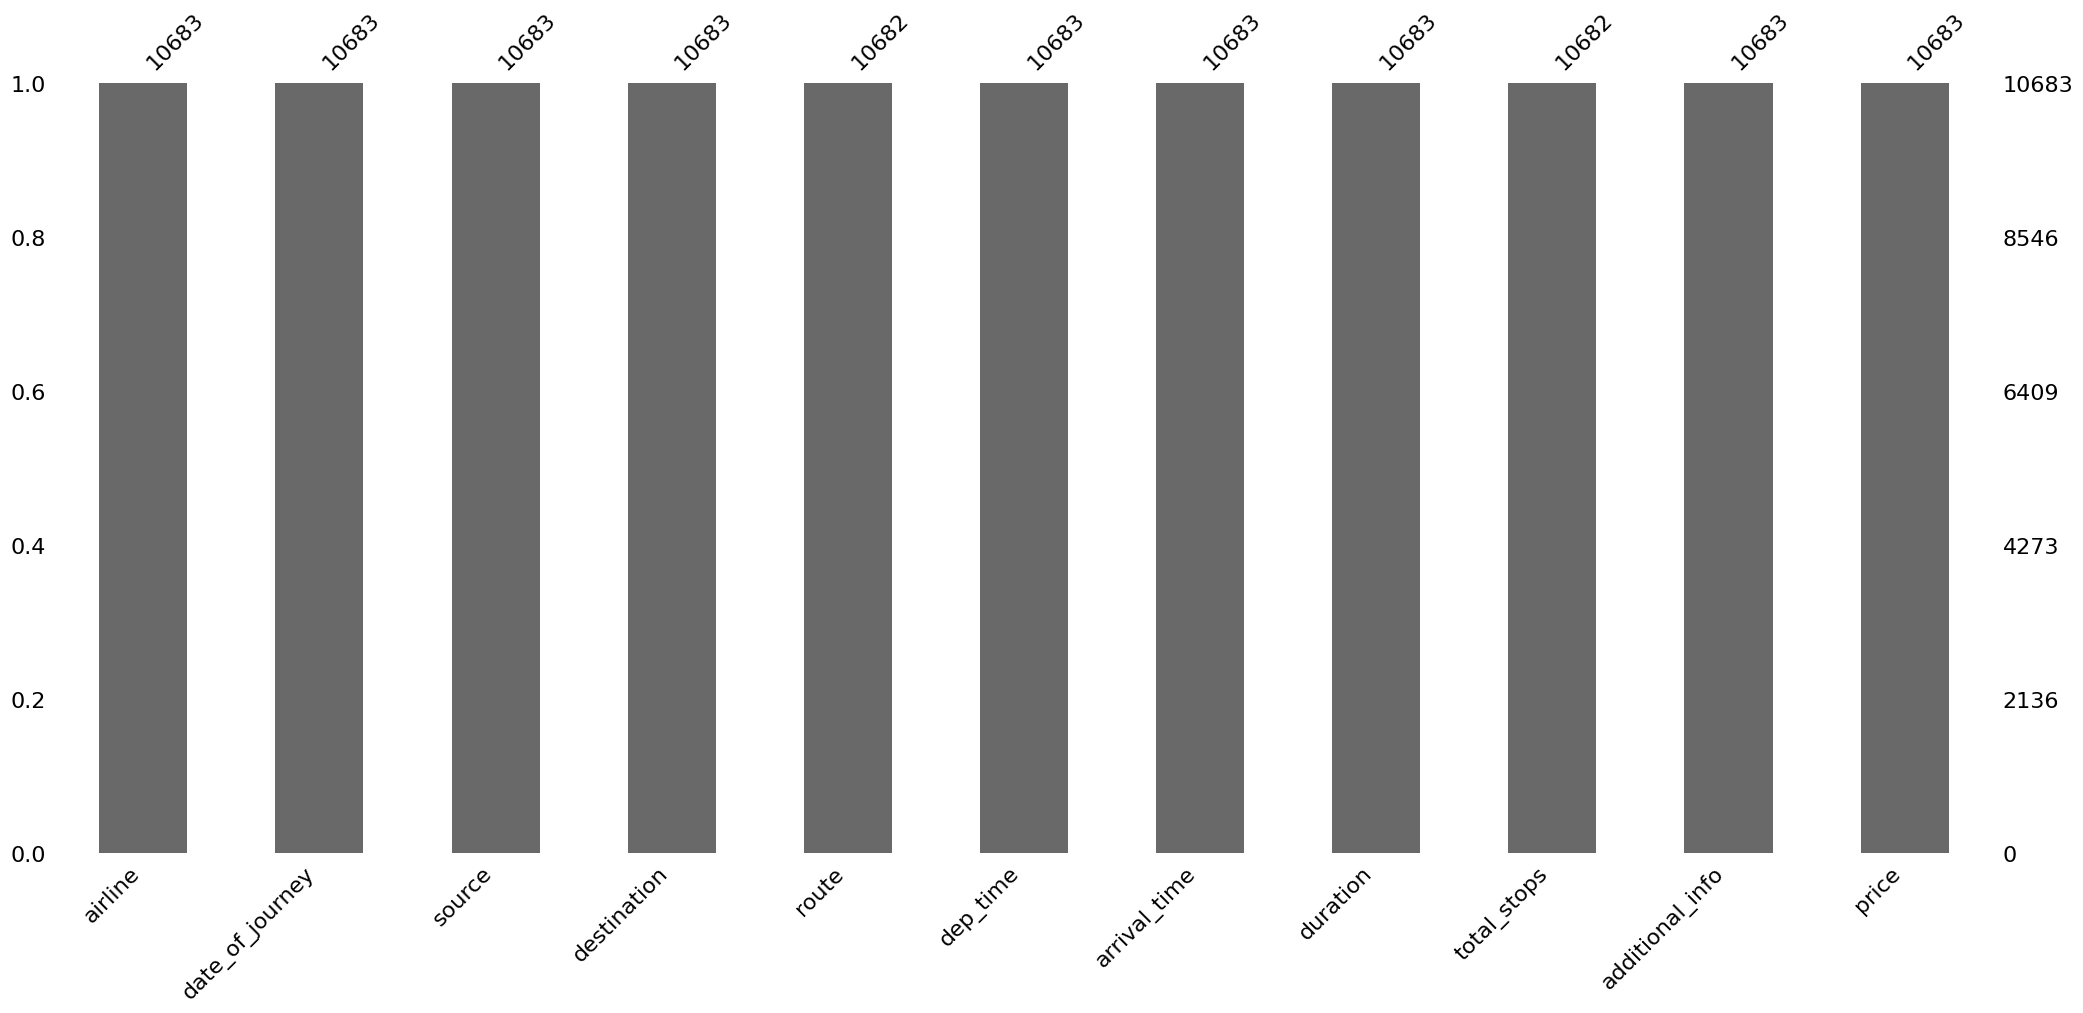

In [8]:
# Visualize the missing values
import missingno as msno
msno.bar(df)
plt.show()

There are a couple of missing values - one in the route column and the other in the total_stops column. As there are only two missing values, we will drop these rows from the dataset.

In [9]:
# Drop the null values
df.dropna(inplace=True)

In [10]:
df.isnull().sum()

airline            0
date_of_journey    0
source             0
destination        0
route              0
dep_time           0
arrival_time       0
duration           0
total_stops        0
additional_info    0
price              0
dtype: int64

### Data Cleaning

In [11]:
# Datatypes
df.dtypes

airline            object
date_of_journey    object
source             object
destination        object
route              object
dep_time           object
arrival_time       object
duration           object
total_stops        object
additional_info    object
price               int64
dtype: object

The columns: date_of_journey, dep_time, and arrival_time, need to be converted into datetime datatype. 

In [12]:
def convert_to_datetime(col):
    """ 
    Converts the column's datatype to datetime
    """
    df[col] = pd.to_datetime(df[col])

In [13]:
df.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'route',
       'dep_time', 'arrival_time', 'duration', 'total_stops',
       'additional_info', 'price'],
      dtype='object')

In [14]:
# Convert columns datatypes to datetime
for i in ['date_of_journey', 'dep_time', 'arrival_time']:
    convert_to_datetime(i)

In [15]:
df.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
route                      object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                   object
total_stops                object
additional_info            object
price                       int64
dtype: object

We will extract the day and month from the date_of_journey column and store the values in a new variable - one for the day and one for the month. After creating the new variables the date_of_journey column will serve of no use, so we will drop it.

In [16]:
# Extract the day from the date_of_journey column
df['journey_day'] = df['date_of_journey'].dt.day

# Extract the month from the date_of_journey column
df['journey_month'] = df['date_of_journey'].dt.month

In [17]:
df.head()

,airline,date_of_journey,source,destination,route,dep_time,arrival_time,duration,total_stops,additional_info,price,journey_day,journey_month
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2022-12-28 22:20:00,2022-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,2022-12-28 05:50:00,2022-12-28 13:15:00,7h 25m,2 stops,No info,7662,5,1
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,2022-12-28 09:25:00,2022-06-10 04:25:00,19h,2 stops,No info,13882,6,9
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,2022-12-28 18:05:00,2022-12-28 23:30:00,5h 25m,1 stop,No info,6218,5,12
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,2022-12-28 16:50:00,2022-12-28 21:35:00,4h 45m,1 stop,No info,13302,3,1


In [18]:
# Drop the date_of_journey column from the dataset
df.drop('date_of_journey', axis=1, inplace=True)

For the arrival_time and dep_time columns, we will extract the hour and minutes.

In [19]:
def extract_hour(df, col):
    """ 
    Extracts the hour from the datetime column
    """
    df[col + '_hour'] = df[col].dt.hour
    
def extract_min(df, col):
    """ 
    Extracts the minute from the datetime column
    """
    df[col + '_minute'] = df[col].dt.minute    
    
def drop_col(df, col):
    """ 
    Drops the column from the dataframe
    """
    df.drop(col, axis=1, inplace=True)

In [20]:
# Call functions for the dep_time column
extract_hour(df, 'dep_time')
extract_min(df, 'dep_time')
drop_col(df, 'dep_time')

In [21]:
# Call functions for the arrival_time column
extract_hour(df, 'arrival_time')
extract_min(df, 'arrival_time')
drop_col(df, 'arrival_time')

In [22]:
df.head()

,airline,source,destination,route,duration,total_stops,additional_info,price,journey_day,journey_month,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,6,9,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,5,12,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,3,1,16,50,21,35


Now we will apply pre-processing on the duration column. We will separate the hour and minutes from the duration column.

In [23]:
dur_list = list(df['duration'])

for i in range(len(dur_list)):
    if len(dur_list[i].split(' ')) == 2:
        pass
    else:
        # Checks if duration contains only the hour
        if 'h' in dur_list[i]:
            # Adds 0 to minutes
            dur_list[i] = dur_list[i] + ' 0m' 
        else:
            dur_list[i] = '0h ' + dur_list[i]

In [24]:
df['duration'] = dur_list

In [25]:
df.head()

,airline,source,destination,route,duration,total_stops,additional_info,price,journey_day,journey_month,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h 0m,2 stops,No info,13882,6,9,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,5,12,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,3,1,16,50,21,35


In [26]:
def hour(x):
    """ 
    Returns the hour part
    """
    return x.split(' ')[0][0: -1]

def minutes(x):
    """ 
    Returns the minute part
    """
    return x.split(' ')[1][0: 2].strip('m')

In [27]:
df['dur_hour'] = df['duration'].apply(hour)

In [28]:
df['dur_min'] = df['duration'].apply(minutes)

In [29]:
df.head()

,airline,source,destination,route,duration,total_stops,additional_info,price,journey_day,journey_month,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dur_hour,dur_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h 0m,2 stops,No info,13882,6,9,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,5,12,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,3,1,16,50,21,35,4,45


In [30]:
drop_col(df, 'duration')

In [31]:
df.dtypes

airline                object
source                 object
destination            object
route                  object
total_stops            object
additional_info        object
price                   int64
journey_day             int64
journey_month           int64
dep_time_hour           int64
dep_time_minute         int64
arrival_time_hour       int64
arrival_time_minute     int64
dur_hour               object
dur_min                object
dtype: object

The duration hour and minute columns should be of type int, so we will convert both columns to an integer datatype.

In [32]:
df['dur_hour'] = df['dur_hour'].astype(int)
df['dur_min'] = df['dur_min'].astype(int)

In [33]:
df.dtypes

airline                object
source                 object
destination            object
route                  object
total_stops            object
additional_info        object
price                   int64
journey_day             int64
journey_month           int64
dep_time_hour           int64
dep_time_minute         int64
arrival_time_hour       int64
arrival_time_minute     int64
dur_hour                int64
dur_min                 int64
dtype: object

#### Finding the categorical value

In [34]:
# Create a list to hold the categorical columns
column = [column for column in df.columns if df[column].dtype == 'object']
print(column)

['airline', 'source', 'destination', 'route', 'total_stops', 'additional_info']


#### Finding the continuous value

In [35]:
# Create a list to hold the continuous columns
continuous_col = [column for column in df.columns if df[column].dtype != 'object']
print(continuous_col)

['price', 'journey_day', 'journey_month', 'dep_time_hour', 'dep_time_minute', 'arrival_time_hour', 'arrival_time_minute', 'dur_hour', 'dur_min']


### Handling categorical data

We are using two main Encoding Techniques to convert categorical data into some numerical format:

1. Nomical data - data that are not in any order -> OneHotEncoding

2. Ordinal data - data are in order -> LabelEncoder

In [36]:
# Create a dataframe to hold the categorical data 
categorical = df[column]

In [37]:
categorical.head()

,airline,source,destination,route,total_stops,additional_info
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info


In [38]:
# Get the value counts for each column
categorical['airline'].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: airline, dtype: int64

In [39]:
# Function to format money tick labels
def format_tick_labels(tick_labels):
    formatted_tick_labels = []
    for label in tick_labels:
        formatted_label = "$"
        label_str = str(label)
        for i, character in enumerate(reversed(label_str)):
            if i > 0 and i % 3 == 0:
                formatted_label += ","
            formatted_label += character
        formatted_tick_labels.append(formatted_label[::-1])
    return formatted_tick_labels

In [40]:
import textwrap

In [41]:
# Function to wrap long xtick labels 
def wrap_labels(ax, width, break_long_words=False):
  labels = []
  for label in ax.get_xticklabels():
      text = label.get_text()
      labels.append(textwrap.fill(text, width=width,
                    break_long_words=break_long_words))
  ax.set_xticklabels(labels, rotation=0)

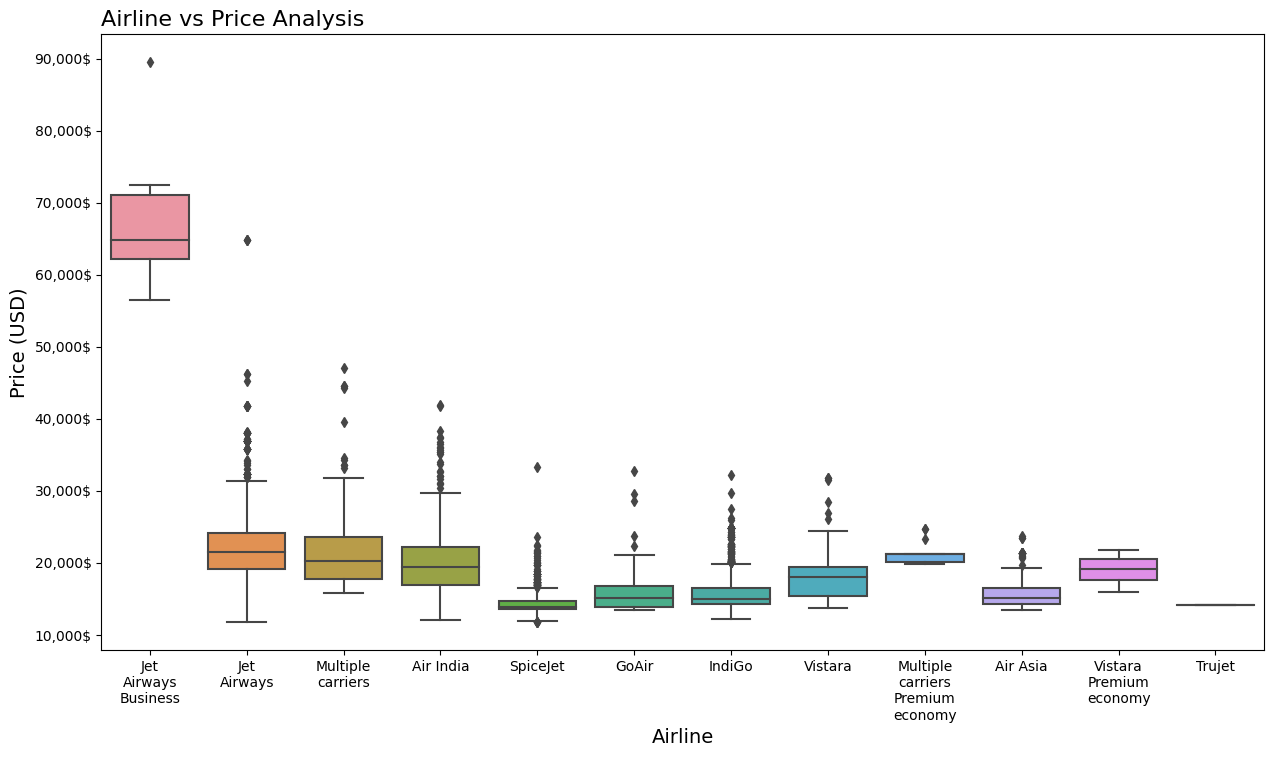

In [42]:
# Create a boxplot to show the airline vs the total ticket price analysis
plt.figure(figsize=(15, 8))
ax = sns.boxplot(x='airline', y='price', data=df.sort_values('price', ascending=False))

# Format title and axes labels
ax.set_title('Airline vs Price Analysis', fontsize=16, loc='left')
ax.set_xlabel('Airline', fontsize=14)
ax.set_ylabel('Price (USD)', fontsize=14)

# Format tick labels
tick_labels = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000]
formatted_tick_labels = format_tick_labels(tick_labels)

# Set the tick labels
ax.set_yticklabels(formatted_tick_labels)

# Call the function
wrap_labels(ax, 10)

plt.show()

Visually, it's clear to see that Jet Airways Business have the highest ticket prices, while the remaining airlines seem to have a similar median value.  

As airline, source, and destination are Nominal Categorical data, we will perform OneHotEncoding.

In [43]:
# Perform OneHotEncoding on airline data
airline = pd.get_dummies(categorical['airline'], drop_first=True)

In [44]:
airline.head()

,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


In [45]:
categorical['source'].value_counts()

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: source, dtype: int64

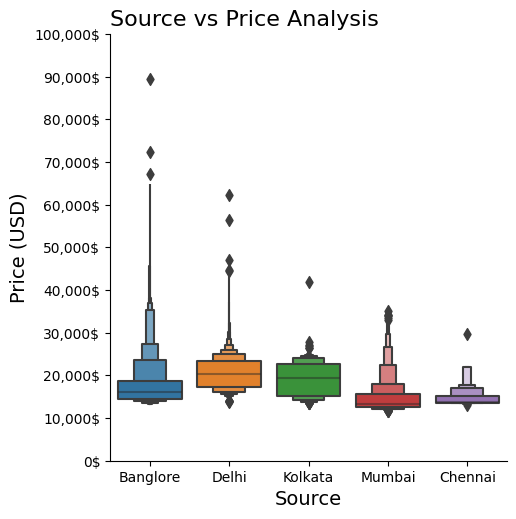

In [46]:
# Create a catplot to show the source vs the total ticket price analysis
ax = sns.catplot(x='source', y='price', data=df.sort_values('price', ascending=False), kind='boxen')

# Format title and axes labels
plt.title('Source vs Price Analysis', fontsize=16, loc='left')
plt.xlabel('Source', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)

# Format tick labels
tick_labels = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]
formatted_tick_labels = format_tick_labels(tick_labels)

# Set the tick labels
ax.set_yticklabels(formatted_tick_labels)

plt.show()

In [47]:
# Perform OneHotEncoding on source column
source = pd.get_dummies(categorical['source'], drop_first=True)
source.head()

,Chennai,Delhi,Kolkata,Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [48]:
categorical['destination'].value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: destination, dtype: int64

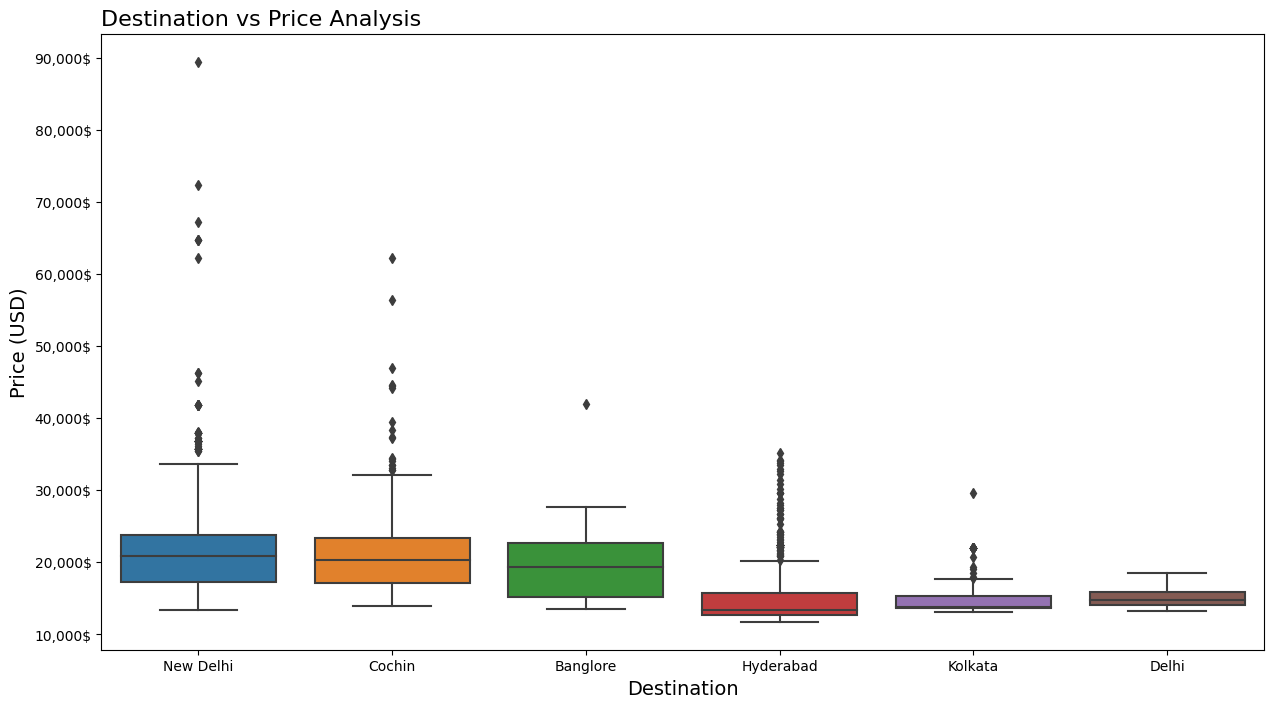

In [49]:
# Create a boxplot to show the destination vs the total ticket price analysis
plt.figure(figsize=(15, 8))
ax = sns.boxplot(x='destination', y='price', data=df.sort_values('price', ascending=False))

# Format title and axes labels
ax.set_title('Destination vs Price Analysis', fontsize=16, loc='left')
ax.set_xlabel('Destination', fontsize=14)
ax.set_ylabel('Price (USD)', fontsize=14)

# Format tick labels
tick_labels = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000]
formatted_tick_labels = format_tick_labels(tick_labels)

# Set the tick labels
ax.set_yticklabels(formatted_tick_labels)

plt.show()

In [50]:
# Perform OneHotEncoding on destination column
destination = pd.get_dummies(categorical['destination'], drop_first=True)
destination.head()

,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


As route and total_stops are Ordinal Categorical data, we will perform LabelEncoding.

In [51]:
categorical['route'].value_counts()

DEL → BOM → COK          2376
BLR → DEL                1552
CCU → BOM → BLR           979
CCU → BLR                 724
BOM → HYD                 621
                         ... 
CCU → VTZ → BLR             1
CCU → IXZ → MAA → BLR       1
BOM → COK → MAA → HYD       1
BOM → CCU → HYD             1
BOM → BBI → HYD             1
Name: route, Length: 128, dtype: int64

In [52]:
# Separate the routes in the route column
categorical['route1']=categorical['route'].str.split('→').str[0]
categorical['route2']=categorical['route'].str.split('→').str[1]
categorical['route3']=categorical['route'].str.split('→').str[2]
categorical['route4']=categorical['route'].str.split('→').str[3]
categorical['route5']=categorical['route'].str.split('→').str[4]

In [53]:
categorical.head()

,airline,source,destination,route,total_stops,additional_info,route1,route2,route3,route4,route5
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,BLR,DEL,NaN,NaN,NaN
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,CCU,IXR,BBI,BLR,NaN
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,DEL,LKO,BOM,COK,NaN
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,CCU,NAG,BLR,NaN,NaN
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,BLR,NAG,DEL,NaN,NaN


In [54]:
drop_col(categorical, 'route')

In [55]:
categorical.isnull().sum()

airline                0
source                 0
destination            0
total_stops            0
additional_info        0
route1                 0
route2                 0
route3              3491
route4              9116
route5             10636
dtype: int64

There are a number of missing values in route3, route4, and route5 so we will fill the nulls with 'None'.

In [56]:
categorical.columns

Index(['airline', 'source', 'destination', 'total_stops', 'additional_info',
       'route1', 'route2', 'route3', 'route4', 'route5'],
      dtype='object')

In [57]:
for i in ['route3', 'route4', 'route5']:
    categorical[i].fillna('None', inplace=True)

In [58]:
categorical.isnull().sum()

airline            0
source             0
destination        0
total_stops        0
additional_info    0
route1             0
route2             0
route3             0
route4             0
route5             0
dtype: int64

In [59]:
for i in categorical.columns:
    print(' {} has total {} categories'.format(i, len(categorical[i].value_counts())))

 airline has total 12 categories
 source has total 5 categories
 destination has total 6 categories
 total_stops has total 5 categories
 additional_info has total 10 categories
 route1 has total 5 categories
 route2 has total 45 categories
 route3 has total 30 categories
 route4 has total 14 categories
 route5 has total 6 categories


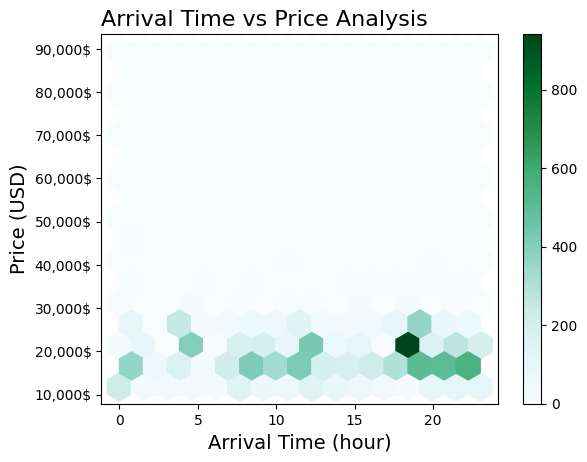

In [60]:
# Create a hexbin to show the source vs the ticket price analysis
ax = df.plot.hexbin(x='arrival_time_hour', y='price', gridsize=15)

# Format title and axes labels
plt.title('Arrival Time vs Price Analysis', fontsize=16, loc='left')
plt.xlabel('Arrival Time (hour)', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)

# Format tick labels
tick_labels = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]
formatted_tick_labels = format_tick_labels(tick_labels)

# Set the tick labels
ax.set_yticklabels(formatted_tick_labels)

plt.show()


In [61]:
# apply LabelEncoder
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [62]:
for i in ['route1', 'route2', 'route3', 'route4', 'route5']:
    categorical[i] = encoder.fit_transform(categorical[i])   

In [63]:
categorical.head()

,airline,source,destination,total_stops,additional_info,route1,route2,route3,route4,route5
0,IndiGo,Banglore,New Delhi,non-stop,No info,0,13,29,13,5
1,Air India,Kolkata,Banglore,2 stops,No info,2,25,1,3,5
2,Jet Airways,Delhi,Cochin,2 stops,No info,3,32,4,5,5
3,IndiGo,Kolkata,Banglore,1 stop,No info,2,34,3,13,5
4,IndiGo,Banglore,New Delhi,1 stop,No info,0,34,8,13,5


As the additional_info column isn't meaningful in our analysis, we will drop the column from the dataset.

In [64]:
drop_col(categorical, 'additional_info')

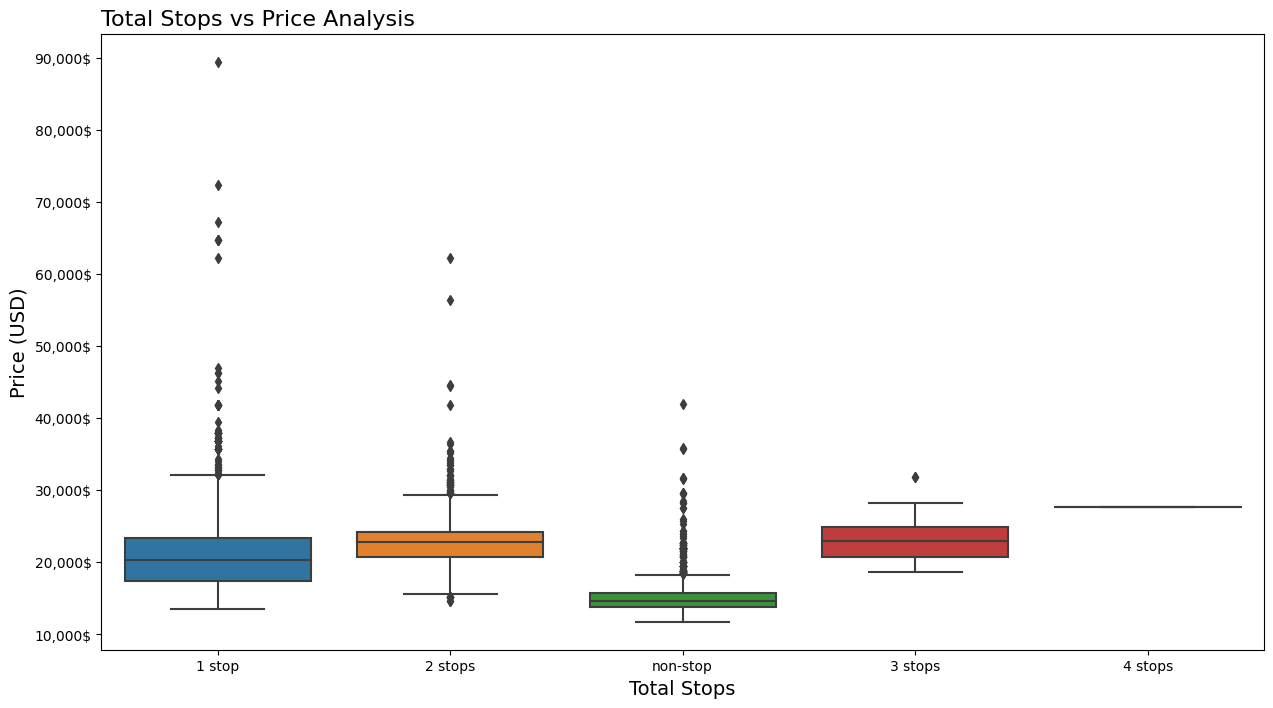

In [65]:
# Create a boxplot to show the total stops vs the ticket price analysis
plt.figure(figsize=(15, 8))
ax = sns.boxplot(x='total_stops', y='price', data=df.sort_values('price', ascending=False))

# Format title and axes labels
ax.set_title('Total Stops vs Price Analysis', fontsize=16, loc='left')
ax.set_xlabel('Total Stops', fontsize=14)
ax.set_ylabel('Price (USD)', fontsize=14)

# Format tick labels
tick_labels = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000]
formatted_tick_labels = format_tick_labels(tick_labels)

# Set the tick labels
ax.set_yticklabels(formatted_tick_labels)

# Call the function
wrap_labels(ax, 10)

plt.show()

From the graph above, all stops seem to be similar in their mean value. 

In [66]:
categorical['total_stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [67]:
# Encode total stops
dict = {'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3, '4 stops': 4}
categorical['total_stops'] = categorical['total_stops'].map(dict)

In [68]:
categorical['total_stops']

0        0
1        2
2        2
3        1
4        1
        ..
10678    0
10679    0
10680    0
10681    0
10682    2
Name: total_stops, Length: 10682, dtype: int64

In [69]:
drop_col(categorical,'source')
drop_col(categorical,'destination')
drop_col(categorical,'airline')

### Data Model

In [70]:
final_df = pd.concat([categorical, airline, source, destination, df[continuous_col]], axis=1)

In [71]:
final_df.head()

,total_stops,route1,route2,route3,route4,route5,Air India,GoAir,IndiGo,Jet Airways,...,New Delhi,price,journey_day,journey_month,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dur_hour,dur_min
0,0,0,13,29,13,5,0,0,1,0,...,1,3897,24,3,22,20,1,10,2,50
1,2,2,25,1,3,5,1,0,0,0,...,0,7662,5,1,5,50,13,15,7,25
2,2,3,32,4,5,5,0,0,0,1,...,0,13882,6,9,9,25,4,25,19,0
3,1,2,34,3,13,5,0,0,1,0,...,0,6218,5,12,18,5,23,30,5,25
4,1,0,34,8,13,5,0,0,1,0,...,1,13302,3,1,16,50,21,35,4,45


In [72]:
pd.set_option('display.max_columns',33)
final_df.head()

,total_stops,route1,route2,route3,route4,route5,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,...,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi,price,journey_day,journey_month,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dur_hour,dur_min
0,0,0,13,29,13,5,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,3897,24,3,22,20,1,10,2,50
1,2,2,25,1,3,5,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,7662,5,1,5,50,13,15,7,25
2,2,3,32,4,5,5,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,13882,6,9,9,25,4,25,19,0
3,1,2,34,3,13,5,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,6218,5,12,18,5,23,30,5,25
4,1,0,34,8,13,5,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,13302,3,1,16,50,21,35,4,45


### Check for outliers

In [73]:
def plot(data, col):
    fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(10, 10))
    sns.distplot(data[col],ax=ax1)
    sns.boxplot(data[col],ax=ax2, orient='h')
    
    # Format plot titles and labels
    ax1.set_title('Distribution of Price Analysis', fontsize=16, loc='left')
    ax1.set_xlabel('Price', fontsize=14)
    ax1.set_ylabel('Density', fontsize=14)
    
    ax2.set_title('Price Value Range', fontsize=16, loc='left')
    ax2.set_xlabel('Cout of Price', fontsize=14)
    ax2.set_ylabel('Price', fontsize=14)
    
    # Format tick labels
    tick_labels = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000]
    formatted_tick_labels = format_tick_labels(tick_labels)

    # Set the tick labels
    ax1.set_xticklabels(formatted_tick_labels)
    ax2.set_xticklabels(formatted_tick_labels)
    
    plt.tight_layout(pad=2.0)
    plt.show()
    

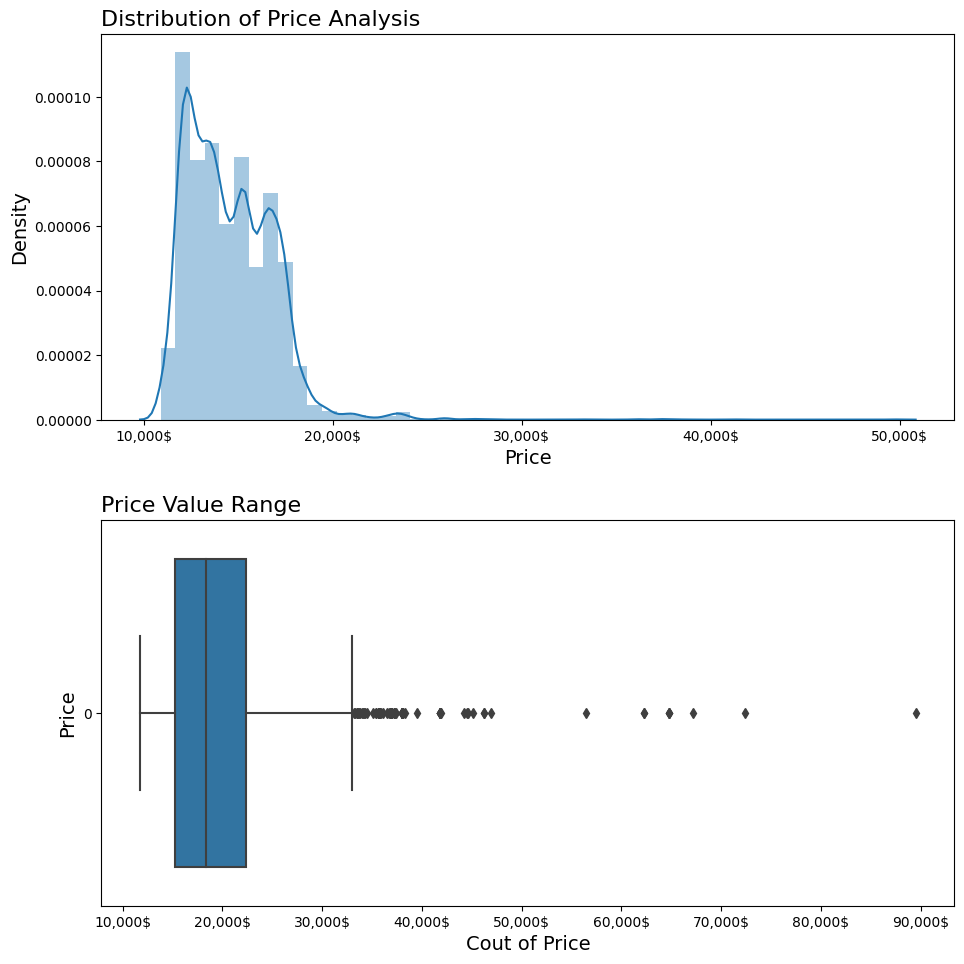

In [74]:
plot(final_df,'price')

### Handling Outliers

As there are some outliers, so we will replace these with the median price value.

In [75]:
final_df['price'] = np.where(final_df['price'] >= 40000, final_df['price'].median(), final_df['price'])

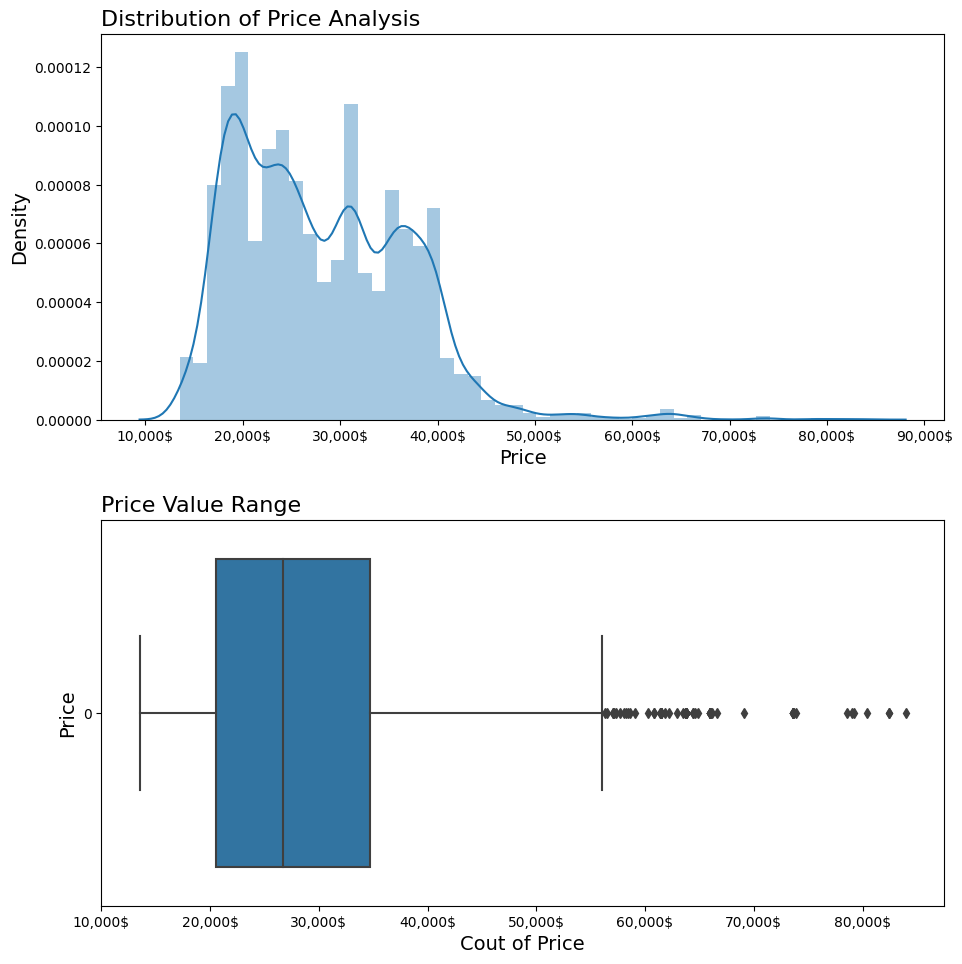

In [76]:
plot(final_df, 'price')

##### Separate the dataset in X and Y columns

In [77]:
X = final_df.drop('price', axis=1)
y = final_df['price']

#### Feature Selection

This section is about finding the best features - those of which have a good relation with the independent variable and reduce the issue of dimensionality reduction.

For this we use mutual_info_classif

In [78]:
from sklearn.feature_selection import mutual_info_classif

In [79]:
mutual_info_classif(X, y)

array([2.13589938, 2.06098114, 2.76791218, 2.26171782, 1.39243035,
       0.76650443, 0.76048538, 0.0937353 , 0.67488388, 0.92476321,
       0.00292644, 0.55521033, 0.00448074, 0.31128329, 0.        ,
       0.22452573, 0.        , 0.17223931, 1.53595978, 0.88537127,
       0.2836598 , 1.54866427, 0.42001311, 0.2926869 , 0.16041789,
       0.35714494, 1.0840337 , 0.84911937, 1.42766945, 1.20693114,
       1.84500996, 1.53838082, 1.78627094, 1.08916744])

In [80]:
imp = pd.DataFrame(mutual_info_classif(X, y), index=X.columns)
imp

,0
total_stops,2.148000
route1,2.063396
route2,2.750289
route3,2.237031
route4,1.513585
route5,0.715991
Air India,0.741663
GoAir,0.105211
IndiGo,0.672163
Jet Airways,0.933112


In [81]:
imp.columns = ['importance']
imp.sort_values(by='importance', ascending=False)

,importance
route2,2.750289
route3,2.237031
total_stops,2.148000
route1,2.063396
arrival_time_hour,1.854742
dur_hour,1.791595
Cochin,1.571661
Delhi,1.548023
arrival_time_minute,1.528089
route4,1.513585


As we can see from the table there are some features that have approx. 0 value, so we will remove it after authorizing it.

In [82]:
# Splitting the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

In [83]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
def predict(ml_model):
    print('Model is: {}'.format(ml_model))
    model= ml_model.fit(X_train,y_train)
    print("Training score: {}".format(model.score(X_train,y_train)))
    predictions = model.predict(X_test)
    print("Predictions are: {}".format(predictions))
    print('\n')
    r2score=r2_score(y_test,predictions) 
    print("r2 score is: {}".format(r2score))
          
    print('MAE:{}'.format(mean_absolute_error(y_test,predictions)))
    print('MSE:{}'.format(mean_squared_error(y_test,predictions)))
    print('RMSE:{}'.format(np.sqrt(mean_squared_error(y_test,predictions))))
     
    sns.distplot(y_test-predictions) 

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

Model is: RandomForestRegressor()
Training score: 0.952359996828801
Predictions are: [ 8460.79       16930.8        13824.23190476 ...  3841.59
  5375.86       10738.542     ]


r2 score is: 0.835732836866827
MAE:1076.5984707907
MSE:2943331.378826916
RMSE:1715.6139947047868


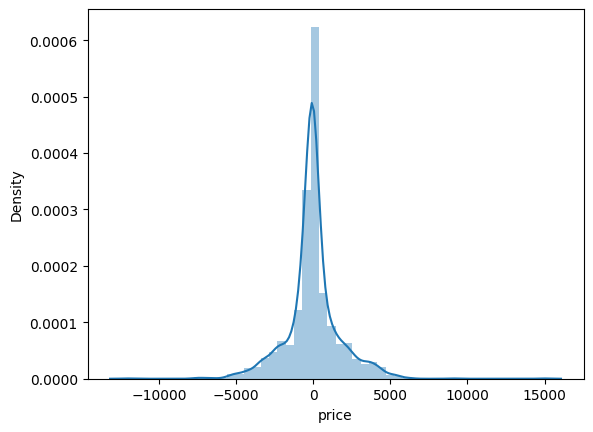

In [85]:
predict(RandomForestRegressor())

From the graph, it is clear that we predicted 84% correctly.

Model is: LogisticRegression()
Training score: 0.342305441778818
Predictions are: [14571. 15237. 10844. ...  4226.  7408. 10262.]


r2 score is: 0.4793605189322444
MAE:1851.3093121197942
MSE:9328793.974730931
RMSE:3054.30744600653


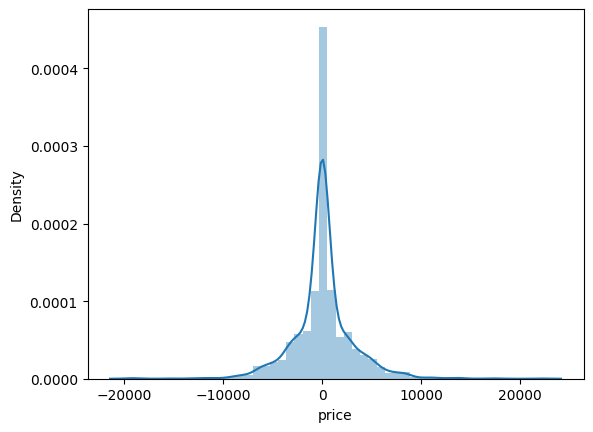

In [86]:
predict(LogisticRegression())

Model is: KNeighborsRegressor()
Training score: 0.7773168169986349
Predictions are: [10401.2 16362.4 12933.2 ...  4210.   9073.  11232.4]


r2 score is: 0.651282796750551
MAE:1689.0028076743097
MSE:6248298.607487132
RMSE:2499.659698336382


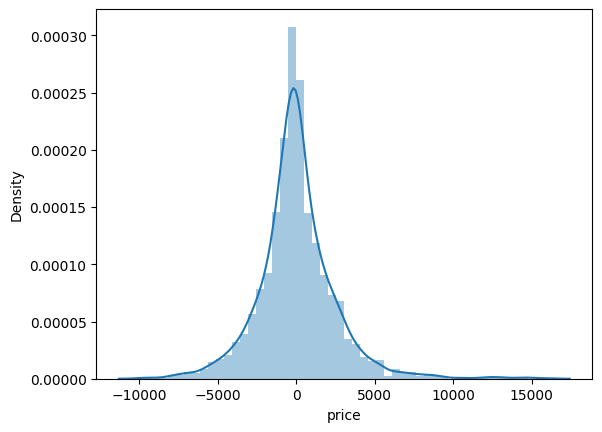

In [87]:
predict(KNeighborsRegressor())

Model is: DecisionTreeRegressor()
Training score: 0.9667772510524137
Predictions are: [ 8996. 18550. 14571. ...  3943.  5054. 10262.]


r2 score is: 0.7388439086642664
MAE:1233.0879737950397
MSE:4679382.682082878
RMSE:2163.188082919023


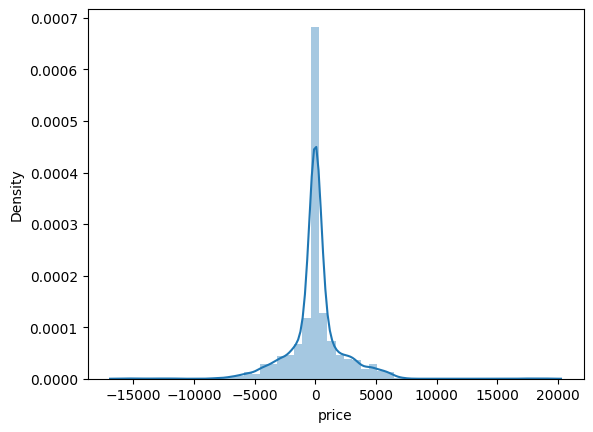

In [88]:
predict(DecisionTreeRegressor())

Model is: SVR()
Training score: 0.0443280602904903
Predictions are: [8526.46202841 8267.76350685 8458.58682126 ... 8291.908066   8452.9288911
 8537.46883076]


r2 score is: 0.05835273679865716
MAE:3302.515543153211
MSE:16872391.807972316
RMSE:4107.601709997248


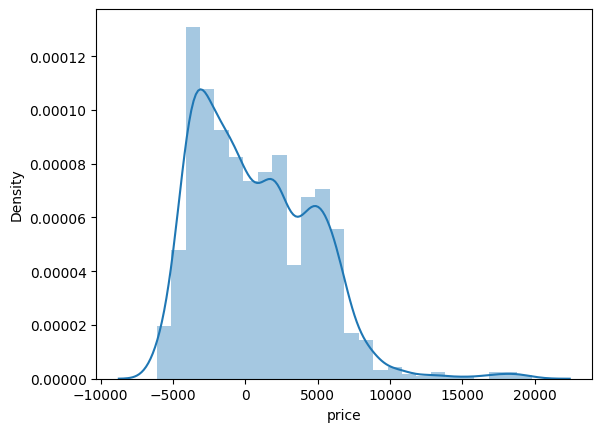

In [89]:
from sklearn.svm import SVR
predict(SVR())

Model is: GradientBoostingRegressor()
Training score: 0.8023952313510914
Predictions are: [ 5721.70151743 17914.41452274 11970.6330701  ...  4591.89767384
  6657.3924801  11342.246736  ]


r2 score is: 0.805790308287008
MAE:1384.5563770862104
MSE:3479840.2114470694
RMSE:1865.4329822984982


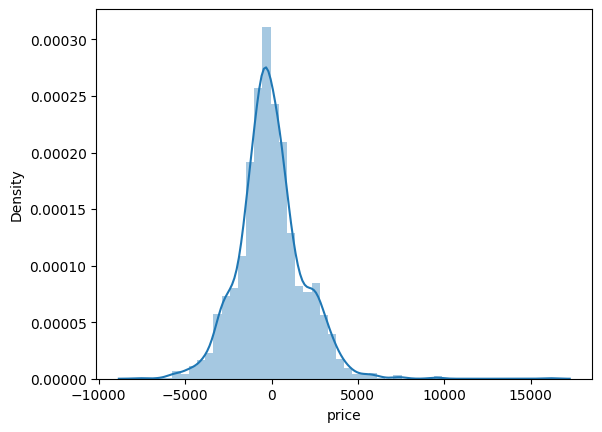

In [90]:
predict(GradientBoostingRegressor())

### Hypertuning the model

In [91]:
from sklearn.model_selection import RandomizedSearchCV

In [92]:
random_grid = {
    'n_estimators' : [100, 120, 150, 180, 200, 220],
    'max_features' : [1.0, 'sqrt'],
    'max_depth' : [5, 10, 15, 20],
}

In [93]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, cv=3, verbose=2, n_jobs=-1,)

rf_random.fit(X_train, y_train)

# Best parameter
rf_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ..max_depth=15, max_features=sqrt, n_estimators=120; total time=   0.5s
[CV] END ..max_depth=15, max_features=sqrt, n_estimators=120; total time=   0.6s
[CV] END ..max_depth=15, max_features=sqrt, n_estimators=120; total time=   0.7s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   1.1s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   1.1s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   1.1s
[CV] END ..max_depth=15, max_features=sqrt, n_estimators=150; total time=   0.7s
[CV] END ..max_depth=15, max_features=sqrt, n_estimators=150; total time=   0.7s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=180; total time=   0.4s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=180; total time=   0.4s
[CV] END ..max_depth=15, max_features=sqrt, n_estimators=150; total time=   0.7s
[CV] END ...max_depth=5, max_features=sqrt, n_es

{'n_estimators': 120, 'max_features': 1.0, 'max_depth': 10}

In [94]:
# Best parameter
rf_random.best_params_

{'n_estimators': 120, 'max_features': 1.0, 'max_depth': 10}

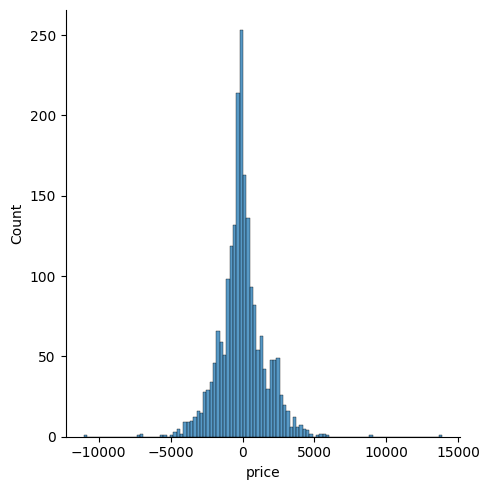

In [95]:
# Predicting the values
prediction = rf_random.predict(X_test)

# Distribution plot between actual value and predicted value
sns.displot(y_test-prediction)

In [96]:
r2_score(y_test, prediction)

0.8565190813318969

##### After hypertuning, the accuracy increased. 

#### Save model for future use

In [97]:
import pickle

# Save the model
with open('./pretrained_model.pkl', 'wb') as f:
    pickle.dump(rf, f)
